# Neural FCA

## Initialization

Firstly, let's install all the dependencies

In [ ]:
import torch
from IPython.display import clear_output

print(torch.__version__)

1.13.0+cu116


Now, we know current version of torch and can install required libraries.

In [ ]:
!pip install fcapy==0.1.4.1
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 7.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 241 kB 6.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 9.4 MB 6.5 MB/s 
Looking in i

Secondly, let's connect my google drive where I have saved the dataset and .py file for neural fca.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/'Colab Notebooks'/OSDA_neural_FCA/
!ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/OSDA_neural_FCA
 diagnosis.csv	 MINE.ipynb	   neural_lib.py  'Копия MINE.ipynb'
 Final.ipynb	 NeuralFCA.ipynb   __pycache__


In [ ]:
import torch
import numpy as np
import pandas as pd

from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

plt.rcParams['figure.facecolor'] = (1,1,1,1)
# sns.set()

Now let's connect the file itself to work with neural fca.

In [ ]:
import neural_lib as nl

## Dataset

LINK TO DATASET: https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations

This dataset has 120 rows, 5 binary and 1 numerical attributes and 2 target variables.

The main goal of this dataset is to help predict two diseases of urinary system: an acute inflammations of urinary bladder (or cystitis in medical terms) and an acute nephritis. Each instance (a row in the dataset) represents an potential patient. 

In [ ]:
df = pd.read_csv('diagnosis.csv')
df.head()

,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing,Micturition pains,Burning of urethra,Inflammation of urinary bladder,Nephritis of renal pelvis origin
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


In [ ]:
df.shape

(120, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Temperature of patient            120 non-null    float64
 1   Occurrence of nausea              120 non-null    object 
 2   Lumbar pain                       120 non-null    object 
 3   Urine pushing                     120 non-null    object 
 4   Micturition pains                 120 non-null    object 
 5   Burning of urethra                120 non-null    object 
 6   Inflammation of urinary bladder   120 non-null    object 
 7   Nephritis of renal pelvis origin  120 non-null    object 
dtypes: float64(1), object(7)
memory usage: 7.6+ KB


## Binarization strategy

Let's look to dataset's attributes and their values:
1. Temperature of patient - integer value;
2. Occurrence of nausea - "yes" or "no";
3. Lumbar pain - "yes" or "no";
4. Urine pushing (continuous need for urination) - "yes" or "no";
5. Micturition pains - "yes" or "no";
6. Burning of urethra, itch, swelling of urethra outlet - "yes" or "no".

Our targets for binary classification:
1. Inflammation of urinary bladder - "yes" or "no";
2. Nephritis of renal pelvis origin - "yes" or "no".

In this work I will stop on one target, namely "Inflammation of urinary bladder" or "Cystitis" in medical terms.

Primarily let's rename our attributes for better usability.

In [ ]:
df.rename(columns = {
    "Temperature of patient": "t",
    "Occurrence of nausea":'s1', 
    "Lumbar pain":'s2',
    "Urine pushing":'s3',
    "Micturition pains":'s4',
    "Burning of urethra":'s5',
    "Inflammation of urinary bladder":'diag1',
    "Nephritis of renal pelvis origin":'diag2',
    }, inplace = True)
df.head()

,t,s1,s2,s3,s4,s5,diag1,diag2
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


So, now I need to binarize only one attribute, namely "Temperature of patient", let's see its distribution and boundary values.

Min patient temperature in data = 35.5
Max patient temperature in data = 41.5



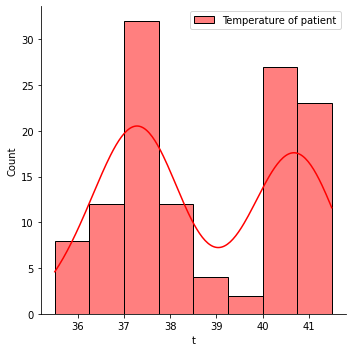

In [ ]:
min_temp = min(df['t'])
max_temp = max(df['t'])
print(f"Min patient temperature in data = {min_temp}\nMax patient temperature in data = {max_temp}\n")

sns.displot(df['t'], color='red', label="Temperature of patient", kde=True)
plt.legend()
plt.show()

We see that mostly near 37-37.5 and 40-41.5 degrees Celsius.

I am going to binarize this attribute based on the source [[1]](https://www.tuasaude.com/en/how-to-tell-if-you-have-a-fever/): 
* false if temperature $\in[35.5,37.2]$;
* true if temperature $\in[37.3,41.5]$.



In [ ]:
cat_temp = pd.cut(df['t'], [min_temp, 37.3, max_temp+1], right=False, labels=[False, True])
cat_temp

0      False
1      False
2      False
3      False
4      False
       ...  
115     True
116     True
117     True
118     True
119     True
Name: t, Length: 120, dtype: category
Categories (2, object): [False < True]

Now, it is time to concatenate our binary table of attributes.

In [ ]:
df_cat = df[['s1', 's2', 's3', 's4', 's5']].join([cat_temp])
df_bin = df_cat.replace(['yes', 'no'], [True, False])
df_bin = df_bin.astype('bool')

Let's also make beauitifull numeration for data.

In [ ]:
s = pd.Series([f'case {i}' for i in range(df.shape[0])])
df_bin = df_bin.set_index([s])
df_bin.head()

,s1,s2,s3,s4,s5,t
case 0,False,True,False,False,False,False
case 1,False,False,True,True,True,False
case 2,False,True,False,False,False,False
case 3,False,False,True,True,True,False
case 4,False,True,False,False,False,False


Let's make a target feature table.

In [ ]:
df_target1 = df["diag1"]
df_target1 = df_target1.replace(['yes', 'no'], [True, False])
df_target1

0      False
1       True
2      False
3       True
4      False
       ...  
115    False
116    False
117    False
118    False
119    False
Name: diag1, Length: 120, dtype: bool

And finally, let's split the data into train and test ones in ratio 80% to 20 % (the most common ratio).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_bin, df_target1, test_size=0.2, random_state=59, shuffle=True)

## Prediction quality measure

I prefer to use the **F1 score** because it maintains a balance between precision and recall for the classifier and it gives a better measure of the incorrectly classified cases than the accuracy metric.

## Fitting and testing the network on the task

Firstly, let's put binarized data in FormalContext and compute monotone ConceptLattice.

In [ ]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (96 objects, 6 attributes, 301 connections)
        |s1|s2|s3|s4|s5|t|
case 10 |  |  | X| X| X| |
case 96 |  | X| X|  | X|X|
case 100|  | X| X|  | X|X|
case 12 |  | X|  |  |  | |
case 112| X| X|  | X|  |X|
case 43 |  |  | X|  |  |X|
case 63 |  | X| X|  | X|X|
case 22 |  | X|  |  |  | |
case 62 |  | X| X|  | X|X|
case 24 |  |  | X| X| X| |
..........................
..........................
case 95 | X| X|  | X|  |X|
case 0  |  | X|  |  |  | |
case 57 |  | X|  |  |  |X|
case 53 |  |  | X| X| X|X|
case 79 | X| X| X| X| X|X|
case 107|  |  |  |  |  |X|
case 23 |  |  | X| X| X| |
case 77 |  | X| X|  | X|X|
case 44 |  |  | X|  |  |X|
case 49 |  |  | X| X|  |X|

In [ ]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

20

So, we have 20 formal concepts. Let's compute F1 score for each formal concept (assuming that an object is predicted True if it is in the extent of the concept).

In [ ]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)

Select indices of the best concepts from the lattice. Here and further I take the minimum possible count of best concepts.

In [ ]:
concepts_count = 7
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [ ]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visualizer for the architecture.

In [ ]:
vis = LineVizNx(
    node_label_font_size=14, 
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

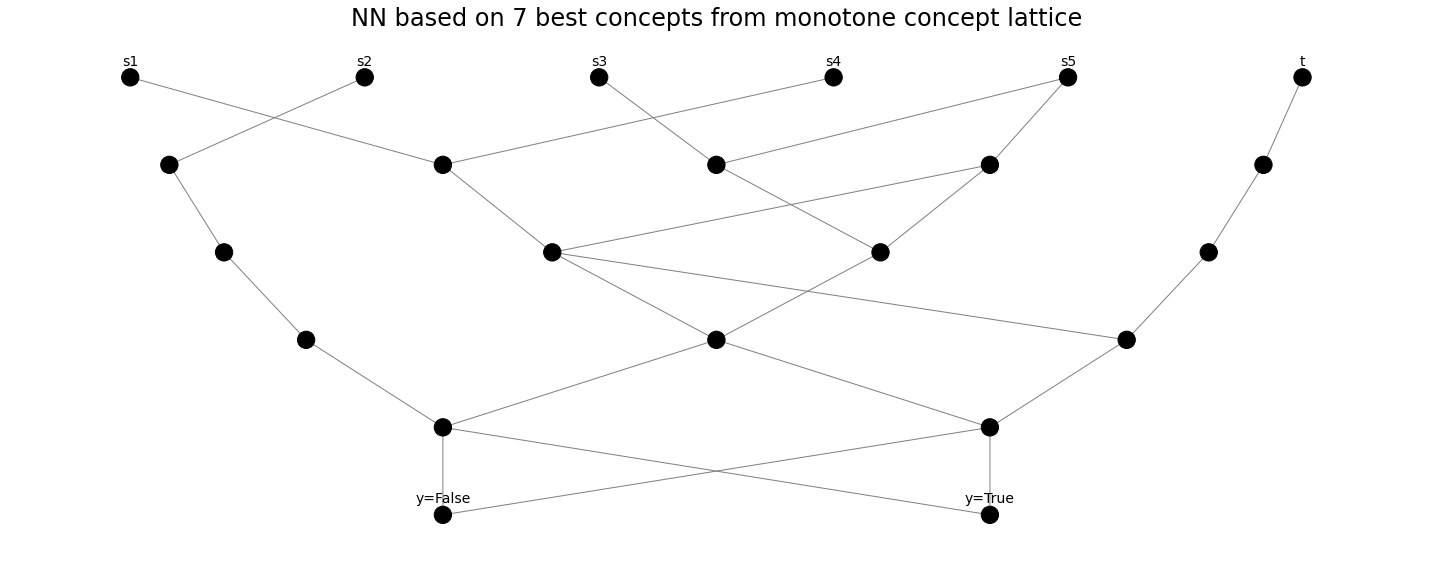

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn.poset, ax=ax, edge_color='grey', 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

It's beautifull, isn't it? Now, we fit the network

In [ ]:
cn.fit(X_train, y_train, n_epochs=50000)

and get predictions

In [ ]:
print('Class predictions \n', cn.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test.values)

Class predictions 
 [ True False  True False  True False False False  True False  True  True
 False False False False  True  True  True False False  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]


Now, let's check F1 score of our prediction

In [ ]:
print("F1 score =", f1_score(y_test.values, cn.predict(X_test).numpy()))

F1 score = 0.6666666666666666


and look at the fitted weights of edges.

In [ ]:
edge_weights = cn.edge_weights_from_network()

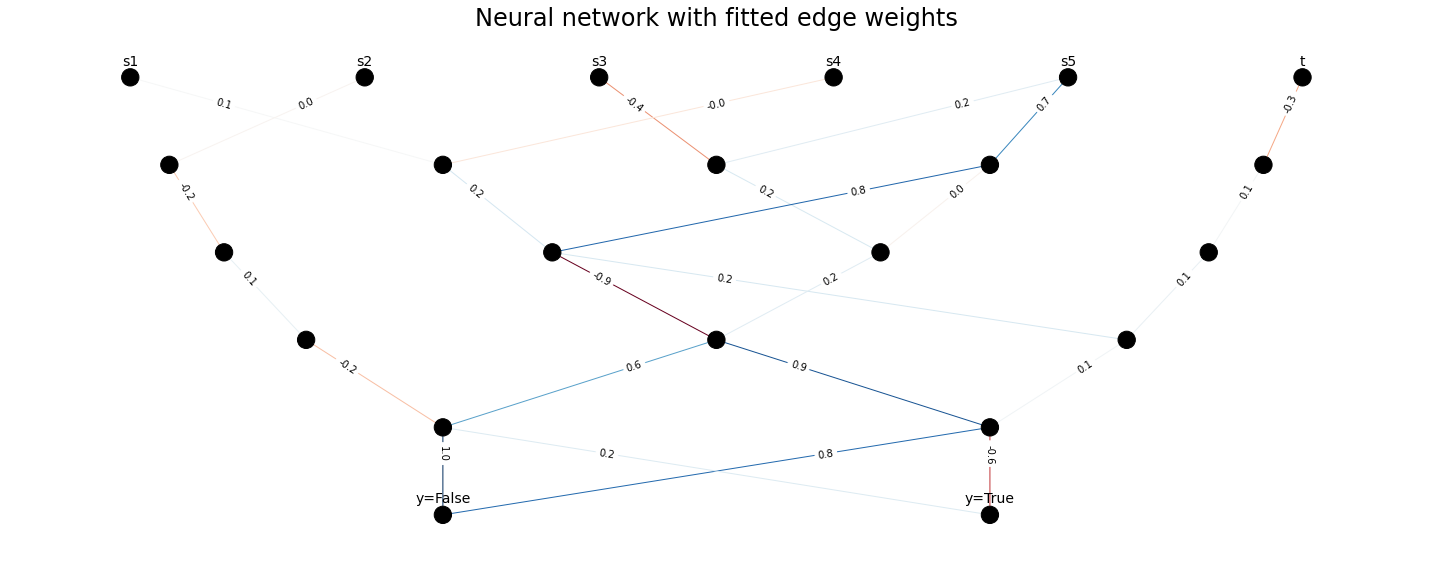

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
# plt.savefig('fitted_network.png')
plt.show()

Ok! We get normal result. Let's go further!

## Another attribute binarization of the original data

In our data we have only one numerical attribute, so I am going to change its way of binarization. Now, let's divide it into 3 groups (based on the source [[2]](https://en.wikipedia.org/wiki/Human_body_temperature): 
* temperature $\in[35.5,36.4]$;
* temperature $\in[36.5,37.5]$;
* temperature $\in[37.6,41.5]$.

In [ ]:
cat_temp2 = pd.cut(df['t'], [min_temp, 36.5, 37.6,  max_temp+1], right=False)#, labels=[0, 1, 2])
df_cat2 = df[['s1', 's2', 's3', 's4', 's5']].join(pd.get_dummies(cat_temp2, prefix='t'))

df_bin2 = df_cat2.replace(['yes', 'no'], [True, False])
df_bin2 = df_bin2.astype('bool')

df_bin2 = df_bin2.set_index([s])
df_bin2.head()

,s1,s2,s3,s4,s5,"t_[35.5, 36.5)","t_[36.5, 37.6)","t_[37.6, 42.5)"
case 0,False,True,False,False,False,True,False,False
case 1,False,False,True,True,True,True,False,False
case 2,False,True,False,False,False,True,False,False
case 3,False,False,True,True,True,True,False,False
case 4,False,True,False,False,False,True,False,False


In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_bin2, df_target1, test_size=0.2, random_state=89, shuffle=True)

In [ ]:
def build_ConceptNetwork(train_data, train_target, concepts_count, score_func=f1_score, score_name='f1_score'):
    K_train = FormalContext.from_pandas(train_data)
    L = ConceptLattice.from_context(K_train, is_monotone=True)

    for c in L:
        y_preds = np.zeros(K_train.n_objects)
        y_preds[list(c.extent_i)] = 1
        c.measures[score_name] = score_func(train_target, y_preds)

    best_concepts = list(L.measures[score_name].argsort()[::-1][:concepts_count])
    assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

    cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(train_target)))
    return K_train, L, cn

K_train2, L2, cn2 = build_ConceptNetwork(X_train2, y_train2, concepts_count=12)

In [ ]:
cn2.fit(X_train2, y_train2, n_epochs=50000)

print('Class predictions \n', cn2.predict(X_test2).numpy().astype(bool))
print('True classes \n', y_test2.values)

print("\nF1 score =", f1_score(y_test2.values, cn2.predict(X_test2).numpy()))

Class predictions 
 [False False  True False False False False False  True  True False False
 False  True False False False  True False  True False False  True False]
True classes 
 [False False  True False  True False False False False False False False
  True  True  True False  True  True False False  True False  True  True]

F1 score = 0.47058823529411764


We get worse results. Let's vizulize our network.

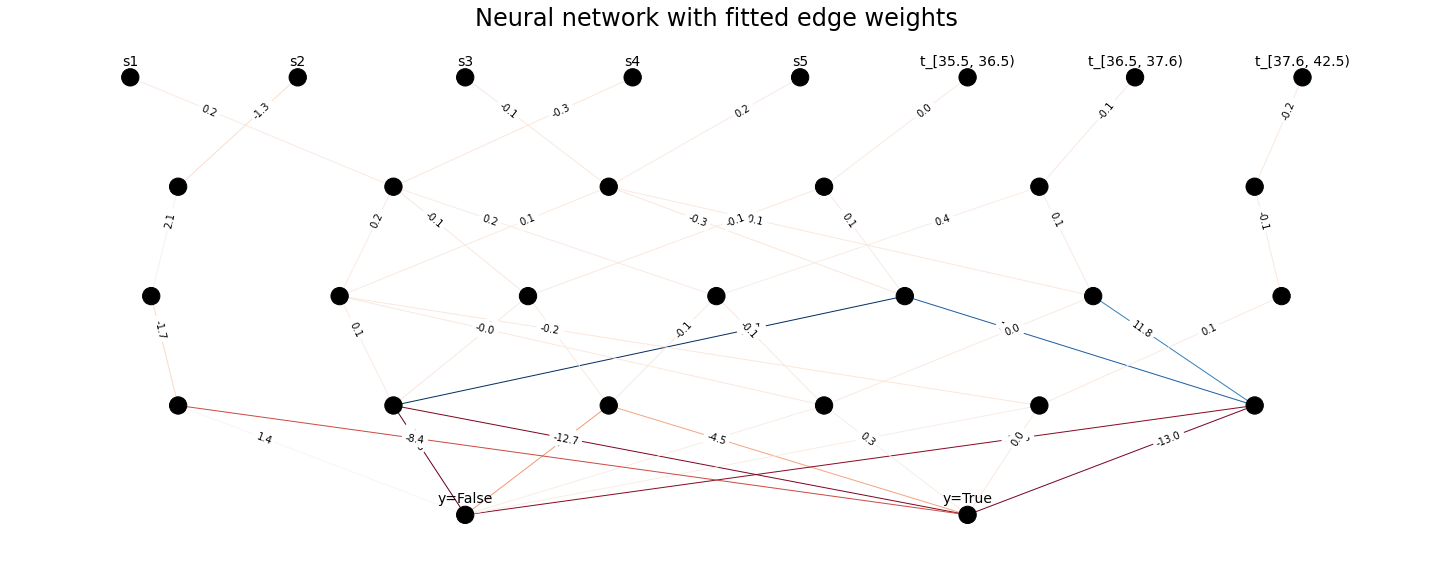

In [ ]:
def visualizer(cn, save=False, title=True):
    fig, ax = plt.subplots(figsize=(20,8))
    
    edge_weights = cn.edge_weights_from_network()

    vis = LineVizNx(
        node_label_font_size=14, 
        node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n',
        edge_cmap="hsv"
        )

    vis.draw_poset(
        cn.poset, ax=ax, node_color='black',
        flg_node_indices=False,
        node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
        edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
        edge_cmap=plt.cm.RdBu,
    )
    nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

    if title:
        plt.title('Neural network with fitted edge weights', size=24, loc='center')
    plt.tight_layout()
    plt.subplots_adjust()
    if save:
        plt.savefig('fitted_network.png')
    plt.show()

visualizer(cn2)

## Another technique to select best concepts from the concept lattice

Ok, now let's work with the first (the best one) model and to try to select best concepts according to accuracy.

In [ ]:
K_train3, L3, cn3 = build_ConceptNetwork(X_train, y_train, concepts_count=9, score_func=accuracy_score, score_name='accuracy_score')

In [ ]:
cn3.fit(X_train, y_train, n_epochs=50000)

In [ ]:
print('Class predictions \n', cn3.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test.values)

print("\nF1 score =", f1_score(y_test.values, cn3.predict(X_test).numpy()))
print("Accuracy =", accuracy_score(y_test.values, cn3.predict(X_test).numpy()))

Class predictions 
 [ True  True False  True  True  True  True  True  True  True  True False
  True  True  True  True  True False  True  True  True  True  True  True]
True classes 
 [False False  True False  True False False False False False False False
  True  True  True False  True  True False False  True False  True  True]

F1 score = 0.5161290322580645
Accuracy = 0.375


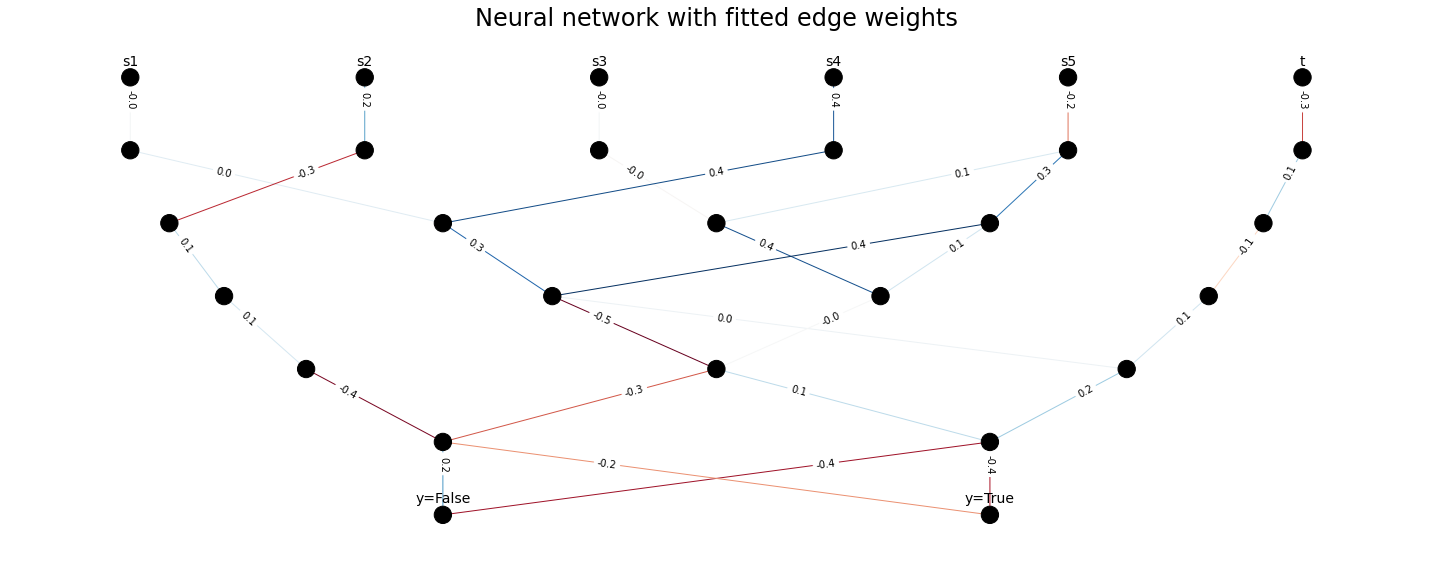

In [ ]:
visualizer(cn3)

The results are worse (based on F1 score). This may be due to the fact that accuracy in concept selection is a poorer estimate than F1 score.

Now, let's check it for model 2, the worst one.

In [ ]:
K_train32, L32, cn32 = build_ConceptNetwork(X_train2, y_train2, concepts_count=14, score_func=accuracy_score, score_name='accuracy_score')

In [ ]:
cn32.fit(X_train2, y_train2, n_epochs=50000)

In [ ]:
print('Class predictions \n', cn32.predict(X_test2).numpy().astype(bool))
print('True classes \n', y_test2.values)
print("\nF1 score =", f1_score(y_test2.values, cn32.predict(X_test2).numpy()))
print("Accuracy =", accuracy_score(y_test2.values, cn32.predict(X_test2).numpy()))

Class predictions 
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
True classes 
 [False False  True False  True False False False False False False False
  True  True  True False  True  True False False  True False  True  True]

F1 score = 0.5882352941176471
Accuracy = 0.4166666666666667


Again, we get worse result than previous model depending on accuracy, but this one is better than model2 (see cn2).

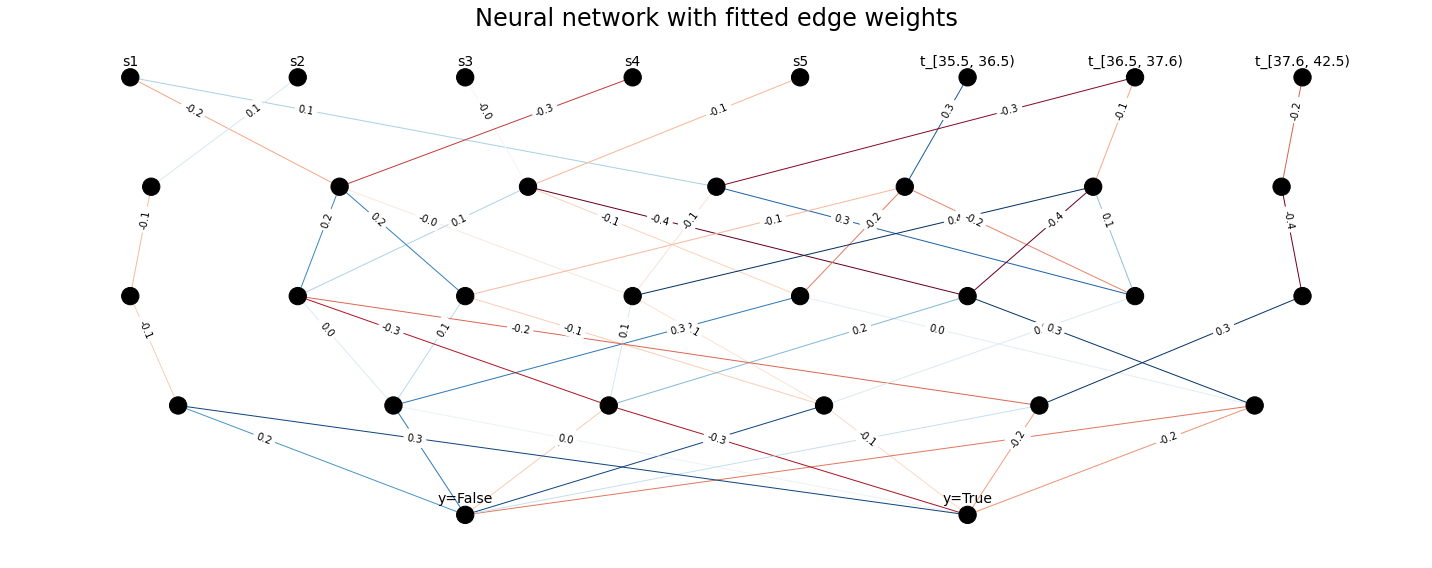

In [ ]:
visualizer(cn32)

## The efficiency of various nonlinearities to put in the network

The default nonlinearity in the network is ReLU. Let's for our first and best model test Leaky ReLU and hyperbolic tangent.

In [ ]:
K_train4, L4, cn4 = build_ConceptNetwork(X_train, y_train, concepts_count=7)
cn4.fit(X_train, y_train, nonlinearity=torch.nn.LeakyReLU, n_epochs=50000)

print('Class predictions \t', cn4.predict(X_test).numpy().astype(bool))
print('True classes \t\t', y_test.values)
print("\n\nF1 score =", f1_score(y_test.values, cn4.predict(X_test).numpy()))

Class predictions 	 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 		 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]


F1 score = 1.0


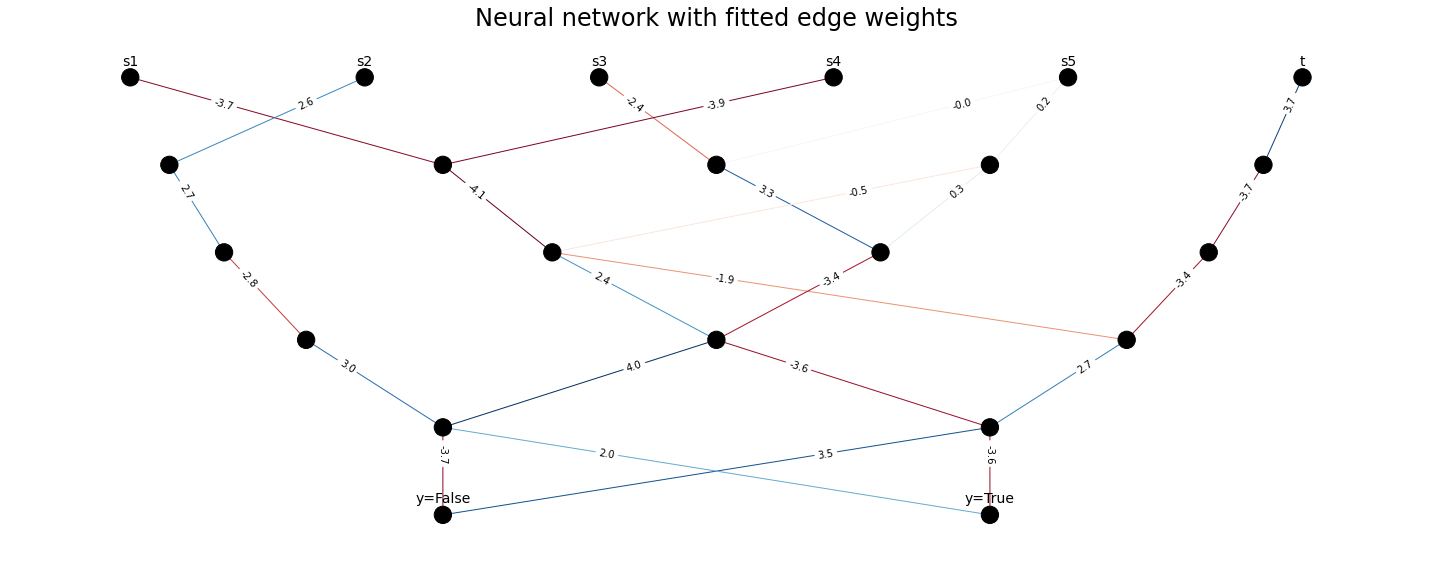

In [ ]:
visualizer(cn4)

Wow, we get the best possible relsult. Now, let's check  hyperbolic tangent.

In [ ]:
K_train5, L5, cn5 = build_ConceptNetwork(X_train, y_train, concepts_count=7)
cn5.fit(X_train, y_train, nonlinearity=torch.nn.Tanh, n_epochs=50000)

print('Class predictions \t', cn5.predict(X_test).numpy().astype(bool))
print('True classes \t\t', y_test.values)
print("\n\nF1 score =", f1_score(y_test.values, cn5.predict(X_test).numpy()))

Class predictions 	 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 		 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]


F1 score = 1.0


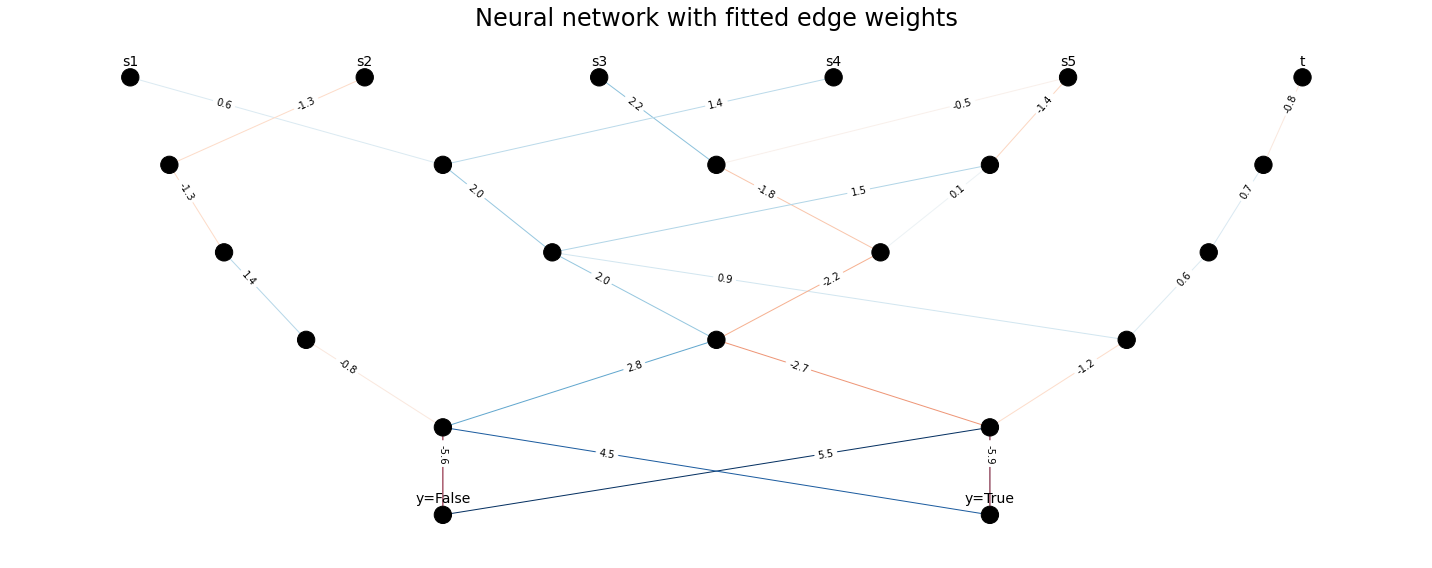

In [ ]:
visualizer(cn5)

Again, great results. Let's now try to improve our second and worst model.

In [ ]:
K_train6, L6, cn6 = build_ConceptNetwork(X_train2, y_train2, concepts_count=12)
cn6.fit(X_train2, y_train2, nonlinearity=torch.nn.LeakyReLU, n_epochs=50000)

print('Class predictions \n', cn6.predict(X_test2).numpy().astype(bool))
print('True classes \n', y_test2.values)
print("\nF1 score =", f1_score(y_test2.values, cn6.predict(X_test2).numpy()))

Class predictions 
 [False False  True False  True False False False False False False False
  True  True  True False  True  True False False  True False  True  True]
True classes 
 [False False  True False  True False False False False False False False
  True  True  True False  True  True False False  True False  True  True]

F1 score = 1.0


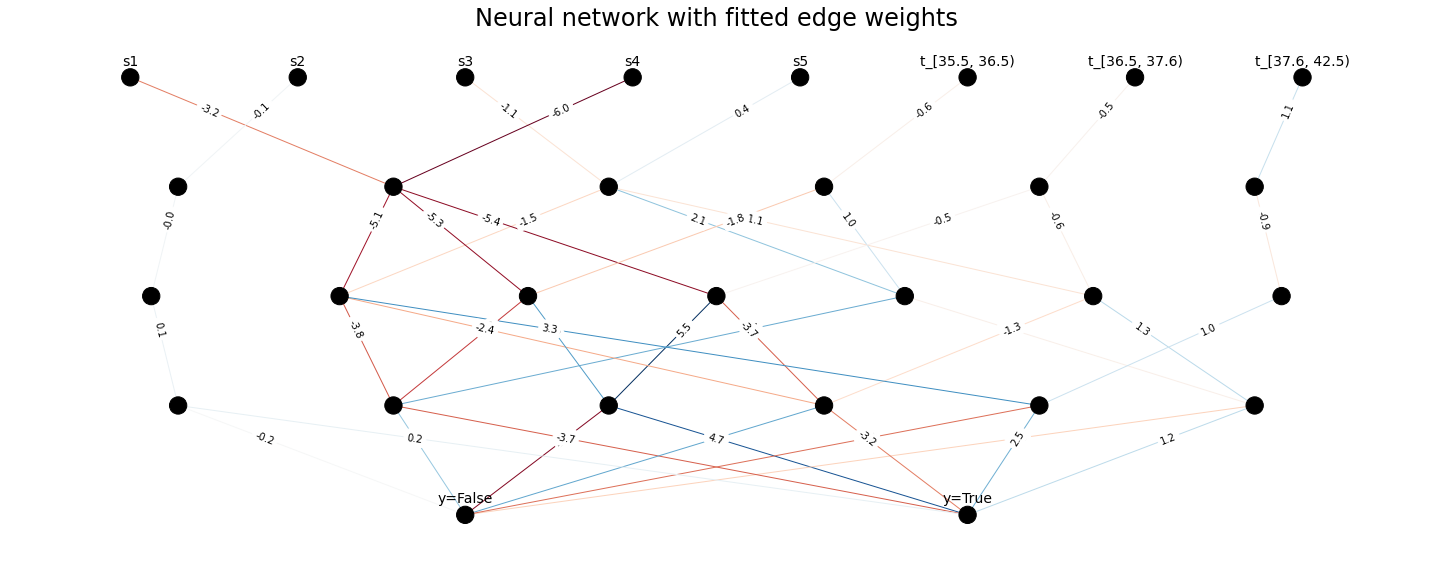

In [ ]:
visualizer(cn6)

In [ ]:
K_train7, L7, cn7 = build_ConceptNetwork(X_train2, y_train2, concepts_count=12)
cn7.fit(X_train2, y_train2, nonlinearity=torch.nn.Tanh, n_epochs=50000)

print('Class predictions \n', cn7.predict(X_test2).numpy().astype(bool))
print('True classes \n', y_test2.values)
print("\nF1 score =", f1_score(y_test2.values, cn7.predict(X_test2).numpy()))

Class predictions 
 [False False  True False  True False False False False False False False
  True  True  True False  True  True False False  True False  True  True]
True classes 
 [False False  True False  True False False False False False False False
  True  True  True False  True  True False False  True False  True  True]

F1 score = 1.0


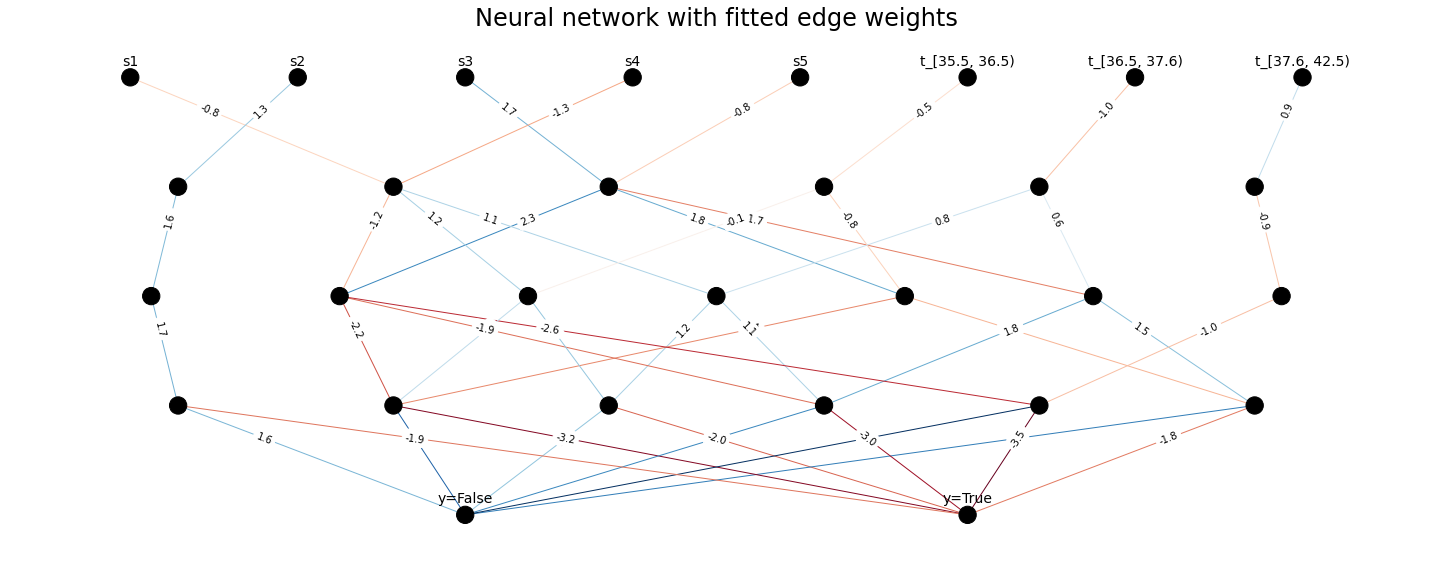

In [ ]:
visualizer(cn7)

Again, in two last examples, we get the best possible results and improve the model as much as possible.

## Comparison of the prediction quality of the proposed model with State-of-the-Art approaches

I am going to compare results of my model with results of Logistic Regression and Random Forest Classifier.

In [ ]:
lr = LogisticRegression(random_state=17)
lr.fit(X_train, y_train)

print('Class predictions \n', lr.predict(X_test).astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test.values, lr.predict(X_test)))

Class predictions 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]

F1 score = 1.0


In [ ]:
rf = RandomForestClassifier(random_state=17)
rf.fit(X_train, y_train)

print('Class predictions \n', rf.predict(X_test).astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test.values, rf.predict(X_test)))

Class predictions 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]

F1 score = 1.0


Ok, we get similar results, but State-of-the-Art approaches work faster.

## List of references

List of references:
1. https://www.tuasaude.com/en/how-to-tell-if-you-have-a-fever/
2. https://en.wikipedia.org/wiki/Human_body_temperature